## Substitution Effect

대체 효과는 두 가지 특성이 예측 정보를 공유할 때 발생한다. 대체 효과는 feature importance 방법의 결과를 편향시킬 수 있다. MDI의 경우 동일한 두 특성이 동일한 확률로 무작위로 선택되기 때문에 그들의 중요도는 반감될 것이다. MDA의 경우 한 가지 특성을 셔플링하는 효과가 다른 효과에 의해 보상될 수 있기 때문에 동일한 두 가지 특성이 중요하더라도 중요하지 않은 것으로 간주될 수 있다.

In [1]:
import pandas as pd
import numpy as np
from FinancialMachineLearning.generator.classification_data import get_test_data

In [2]:
trnsX, cont = get_test_data(
    n_features = 40, 
    n_informative = 5, 
    n_redundant = 30, 
    n_samples = 10000,
    sigma_std = 0.1
)

### Clustered Feature Importance

기저 변경이 필요하지 않은 더 나은 접근 방식은 유사한 특성을 군집화하고 군집 수준에서 특성 중요도 분석을 적용하는 것이다. 구성상 군집은 서로 달라서 substitution effect를 완화시키기 때문이다. 분석은 기저의 변경 없이 특성의 분할에 대해 행해지기 때문에 결과는 보통 직관적이다. Clustered Feature Importance 알고리즘에는 다음의 두 단계가 포함된다.

1. 특성 군집의 수와 구성 요소를 찾는다
2. 개별 특성보다는 유사한 특성의 그룹에 대해 특성 중요도 분석을 적용한다

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from FinancialMachineLearning.feature_importance import *

clf = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 1,
    class_weight = 'balanced',
    min_weight_fraction_leaf = 0
)
bagging = BaggingClassifier(
    estimator = clf,
    n_estimators = 1000,
    oob_score = True
)

fit = bagging.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

#### Step 1. Feature Clustering

먼저 관측된 특성을 척도 공간에 투영해 행렬 $\{X_f\}_{f = 1, \dots, F}$을 만든다. 이 행렬을 형성하기 위한 한 가지 가능성은 상관관계 기반 접근법을 따르는 것이다. 또 다른 가능성은 척도 공간에 그러한 특성을 나타내고자 정보 이론적 개념을 적용하는 것이다. 정보 이론적 척도는 정보성 특성의 비선형 조합의 결과인 중복 특성을 인지할 수 있는 장점이 있다.

둘째, ONC 알고리즘과 같은 군집의 최적 개수와 구성을 결정하는 절차를 적용한다. ONC는 최적의 군집 수와 군집 구성을 찾는데 각 특성이 하나의 군집에만 속한다는 점을 기억하자. 동일한 군집에 속하는 특성은 대량의 정보를 공유하고, 다른 군집에 속하는 특성은 상대적으로 적은 양의 정보만 공유한다. 한 특성이 여러 군집에 걸쳐 있는 여러 특성의 조합인 경우 실루엣 점수가 낮게 나타날 수 있다. ONC는 하나의 특성을 여러 군집에 할당할 수 없기 때문에 이것은 문제다. 이 경우 다음과 같은 변환은 시스템의 다중 공선성을 감소시키는 데 도움이 될 수 있다. 각 군집 $k = 1, \dots, K$에 대해서 해당 군집에 포함된 특성을 잔차 특성으로 교체한다. 여기서 이들 잔차 특성은 군집 $k$ 외부의 특성 정보를 포함하지 않는다. 정확히 하고자 $D_k$를 군집 $k$에 속하는 인덱스 특성 $D = \{1, \dots, F\}$의 부분 집합으로 하자. 여기서 $D_k \subset D, \Vert D_k \Vert > 0, \forall k; D_k \cap D_1 = \varnothing, \forall k \neq l; \cup_{k=1}^K D_k = D$다. 그러면 주어진 특성 $X_i, i \in D_k$에 대해 다음을 적합화함으로써 잔차 특성 $\hat{\epsilon}_i$를 구할 수 있다.

$$X_{n,i} = \alpha_i + \sum_{j \in \{\cup_{i<k} D_l\}} \beta_{i,j} X_{n,j} + \epsilon_{n,i}$$ 

여기서 $n = 1,\dots, N$은 특성별 관찰 인덱스이다. 위의 회귀 분석에서 자유도가 너무 낮을 경우 한 가지 옵션은 각 군집 내 특성의 선형 결합을 설명 변수로 회귀 분석을 수행해 단지 $K-1$개의 베타만을 추정하는 것이다. OLS 잔차의 특성 중 하나는 잔차가 설명 변수와 직교한다는 것이다. 따라서 각 특성 $X_i$를 잔차 특성 $\hat{\epsilon}_i$로 대체함으로써 군집 $k$에만 속하는 정보를 보존하면서 이미 다른 군집에 포함된 정보를 군집 $k$로부터 제거한다. 다시 말하지만 실루엣 점수가 특성들이 각각의 군집에 속한다는 것을 명확하게 나타내는 경우에는 이 변환이 필요하지 않다.

#### Step 2. Clustered Importance

step1에서는 특성 군집의 수와 구성을 식별했다. 여기서는 이 정보를 이용해 개별적인 특성보다는 유사한 특성의 그룹에 MDI와 MDA를 적용한다. 다음에서는 분할 알고리즘이 특성을 군집화했다고 가정한다. 군집화된 특성의 중요도에 대한 개념은 계층적 군집에도 적용할 수 있다.

#### Clustered Mean Decrease Importance

특성의 MDI는 특성이 선택된 모든 노드에서 가중된 불순도 감소량이다. 군집을 구성하는 특성의 MDI 값의 합으로 군집 MDI를 계산한다. 군집 당 하나의 특성이 있는 경우 MDI와 군집 MDI는 동일하다. Ensemble Tree의 경우 각 트리에 대해 군집 MDI가 1개씩 있어, Mean Clustered MDI와 Mead Clustered MDI 주위의 표준 편차를 계산할 수 있으며, 이는 Feature MDI의 경우와 유사하다. 아래의 코드는 Clustered MDI를 추정하는 절차를 구현한다.

In [4]:
def group_mean_std(df0, clstrs) -> pd.DataFrame :
    out = pd.DataFrame(columns = ['mean','std'])
    for i, j in clstrs.items() :
        df1 = df0[j].sum(axis = 1)
        out.loc['C_' + str(i), 'mean'] = df1.mean()
        out.loc['C_' + str(i), 'std'] = df1.std() * df1.shape[0] ** (-0.5)
    return out

def clustered_mean_decrease_importance(fit, feature_names, clstrs) -> pd.DataFrame :
    df0 = {
        i : tree.feature_importances_ for i, tree in enumerate(fit.estimators_)
    }
    df0 = pd.DataFrame.from_dict(df0, orient = 'index')
    df0.columns = feature_names
    df0 = df0.replace(0, np.nan)
    imp = group_mean_std(df0, clstrs)
    imp /= imp['mean'].sum()
    return imp

In [5]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansBase
corr0, clusters, silh = clusterKMeansBase(trnsX.corr(), maxNumClusters = 10, n_init = 10)

In [6]:
c_mdi = clustered_mean_decrease_importance(fit, trnsX.columns, clstrs = clusters)

In [7]:
c_mdi

,mean,std
C_0,0.428508,0.00286
C_1,0.310641,0.002507
C_2,0.260852,0.002045


#### Clustered Mean Decrease Accuracy

특성의 MDA는 특성을 분리한 전후의 알고리즘 성과를 비교함으로써 계산된다. 군집 MDA를 계산할 때 한 번에 하나의 특성을 shuffling하는 대신 주어진 군집을 구성하는 모든 특성을 shuffling한다. 특성별로 군집이 하나 있으면 MDA와 군집 MDA가 동일하다. 아래의 코드는 군집 MDA를 추정하는 절차를 구현한다.

In [8]:
from sklearn.metrics import log_loss
from sklearn.model_selection._split import KFold

def clustered_mean_decrease_accuracy(
        clf, X, y, 
        clstrs, 
        n_splits : int = 10
    ) -> pd.DataFrame :
    cvGen = KFold(n_splits = n_splits)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns = clstrs.keys())
    
    for i, (train, test) in enumerate(cvGen.split(X = X)) :
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit = clf.fit(X = X0, y = y0)
        prob = fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels = clf.classes_)
        for j in scr1.columns :
            X1_ = X1.copy(deep = True)
            for k in clstrs[j] :
                np.random.shuffle(X1_[k].values) # shuffle clusters
            prob = fit.predict_proba(X1_)
            scr1.loc[i, j] = - log_loss(y1, prob, labels = clf.classes_)
    imp = (-1 * scr1).add(scr0, axis = 0)
    imp = imp / (-1 * scr1)
    imp = pd.concat(
        {
            'mean' : imp.mean(),
            'std' : imp.std() * (imp.shape[0]**(-0.5))
        }, axis = 1
    )
    imp.index = ['C_' + str(i) for i in imp.index]
    return imp

In [9]:
c_mda = clustered_mean_decrease_accuracy(
    fit, X = trnsX, 
    y = cont['bin'], 
    clstrs = clusters
)

In [10]:
c_mda

,mean,std
C_0,0.437666,0.037409
C_1,0.386112,0.0335
C_2,0.300678,0.042031


### Experimental Results

이 실험에서는 MDI와 MDA의 비군집 버전에서 사용한 것과 동일한 데이터셋에 대해 군집 MDI 및 MDA 절차를 실험한다. 그 데이터셋은 20개의 특성으로 구성되었는데 그 중 5개는 정보성, 30개는 중복, 5개는 잡음이었다. 먼저 그러한 특징들의 상관관계 행렬에 ONC 알고리즘을 적용한다. 비실험적 설정에서 연구자는 군집화 전에 상관 행렬의 잡음과 주음을 제거해야 한다. 여기서는 방법의 강건성을 테스트하는 문제로서 이 실험에서는 그렇게 하지 않는다.

아래의 그림은 ONC가 6새의 관련 군집이 있음을 정확하게 인식하고, 중복 특성이 도출된 정보성 특성을 포함하는 군집에 중복 특성을 할당한다는 것을 보여준다. 군집 간 상관관계가 낮을 경우 특성을 잔차로 교체할 필요가 없다. 아래의 코드는 이 예를 구현한다.

In [11]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansBase
corr0, clusters, silh = clusterKMeansBase(
    trnsX.corr(), 
    maxNumClusters = 10, 
    n_init = 10
)

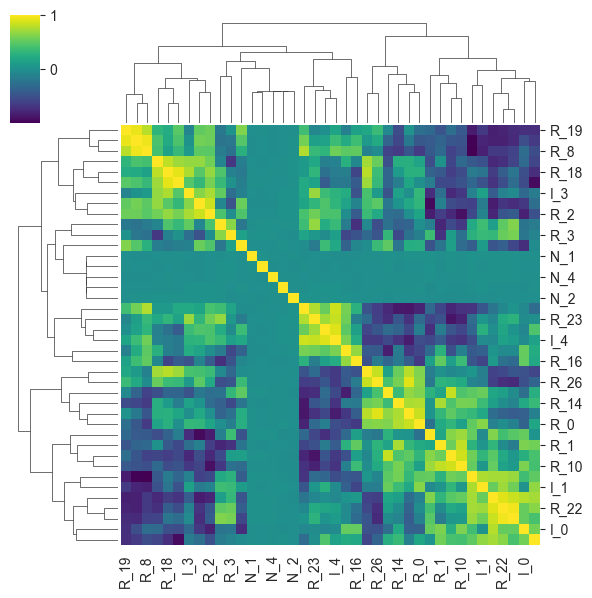

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.clustermap(corr0, cmap = 'viridis', figsize = (6, 6))
plt.show()

다음으로 그 데이터셋에 군집 MDI 방법을 적용한다. 아래의 결과는 군집 MDI출력을 나타내며, 보고된 비군집화된 출력과 비교할 수 있다. 'C_' 접두사는 군집을 나타내며, 'C_5'는 잡음 특성과 연관된 군집이다. 군집화된 특성 'C_1'은 두 번째로 중요하지 않지만, 그 중요도는 'C_5'의 두 배 이상이다. 이는 잡음 특성과 잡음이 없는 특성의 일부 사이에 약간의 중요도 차이가 있었던 것에서 보았던 것과 대조적이다. 따라서 군집 MDI의 방식이 표준 MDI의 방식보다 더 잘 작동하는 것으로 보인다. 아래의 코드는 이러한 결과가 어떻게 계산됐는지 보여 준다.

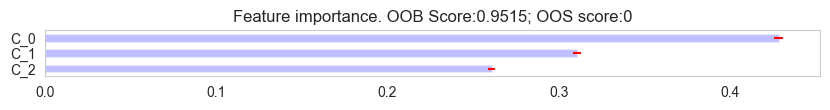

In [13]:
from FinancialMachineLearning.feature_importance.importance import *

plot_feature_importance(
    c_mdi,
    oob_score = oob_score,
    oos_score = 0,
    save_fig = True,
    output_path = './images/C_MDI_feature_importance.png'
)

마지막으로 그 데이터셋에 군집 MDA를 적용한다. 아래의 그림은 비군집화된 출력과 비교할 수 있는 군집 MDA 출력을 보여 준다. 다시 말하지만 'C_5'는 잡음 특성과 연관된 군집으로, 다른 모든 군집은 정보성과 중복 특성과 연관된다. 이 분석은 두 가지 올바른 결론에 도달했다. 

1. 'C_5'는 본질적으로 중요성이 0이며, 관련 없는 것으로 버려져야 한다. 
2. 다른 모든 군집은 중요성이 매우 유사하다. 이는 평균값 주위의 표준 편차를 고려했음에도 불구하고, 일부 비 잡음 특성이 다른 특징들보다 훨씬 더 중요한 것으로 나타났던 그림에서 보았던 것과 대조적이다. 아래의 코드는 이러한 결과가 어떻게 계산되었는지 보여 준다.

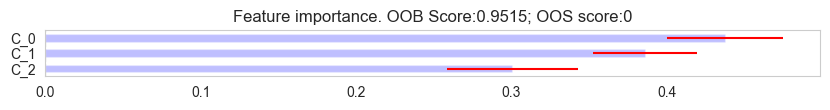

In [14]:
plot_feature_importance(
    c_mda,
    oob_score = oob_score,
    oos_score = 0,
    save_fig = True,
    output_path = './images/C_MDA_feature_importance.png'
)

### Conclusion

대부분의 연구자들은 설명 변수의 중요도를 평가하고자 p-value를 사용한다. 그러나 앞서 보았듯이 p-value는 네 가지 주요 결함에 시달린다. 머신러닝은 대부분의, 또는 모든 결함을 극복하는 특성 중요도 방법을 제공한다.

MDI와 MDA 방법은 데이터의 분포와 구조에 대해 강한 가정을 하지 않고, 특성 중요도를 강력하게 평가한다. p-value값과 달리 MDA는 교차 검증된 실험에서 특성의 중요도를 평가한다. 더욱이 p-value와 달리 군집 MDI와 군집 MDA 추정치는 대체 효과를 효과적으로 제어한다. 그러나 MDI와 MDA의 가장 두드러진 장적은 고전적 유의성 분석과는 달리 이러한 머신러닝 기법이 특정 사양과 무관하게 특성 중요도를 평가한다는 것이다. 그렇게 함으로써 그들은 이론의 발전에 극히 유용한 정보를 제공한다. 일단 연구자가 어떤 현상에 관련된 변수를 알게 되면 연구자는 그것들을 하나로 묶는 메커니즘이나 사양을 찾는 데 주의를 집중할 수 있다.

그 의미는 회귀 분석과 같은 고전적 통계 접근법이 반드시 버신러닝 접근법보다 투명하거나 통찰력 있는 것은 아니라는 것이다. 머신러닝 도구는 블랙박스, 통계적 도구는 화이트박스라는 인식은 거짓이다. 머신러닝의 특성 중요도 방법은 p-value만큼 유용할 뿐만 아니라 경우에 따라서는 보다 통찰력 있고 정확할 수 있다.

마지막으로, 설명하거나 예측하고 하는 것을 주의 깊게 고려해야 한다. 동일한 특성이 서로 다른 유형의 레이블을 설명하거나 예측하는 데 있어서 다양한 중요도를 산출할 수 있다. 가능하다면 이러한 특성 중요도 방법을 앞에서 설명한 모든 레이블링 방법에 적용하는 것이 타당하며, 어떠한 특성과 레이블의 조합이 가장 강력한 이론으로 이어지는지 살펴봐야 한다. 예를 들어, 어떤 종류의 예측을 기반으로도 수익성 있는 전략을 구축할 수 있기 때문에 다음 추세의 부호를 예측하는 것과 다음 5% 수익률의 부호를 예측한느 것에 대해서 무차별할 수 있다.